<a href="https://colab.research.google.com/github/Belal-AI/FSDAwaesf/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from zipfile import ZipFile

In [ ]:
from pathlib import Path

In [ ]:
import os

In [ ]:

import requests
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize,ToTensor
from torchvision.datasets import ImageFolder

In [ ]:
!wget "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
##get the fdqata from wget thaat contain pizza ,suchi ,,etc

--2024-04-03 18:59:13--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2024-04-03 18:59:14--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.1s    

2024-04-03 18:59:14 (109 MB/s) - ‘pizza_steak

In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/pizza_steak_sushi.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/pizza_steak_suchi_data")



In [ ]:
training_data_trans=Compose([Resize((224,224)),ToTensor()]) ## do some resize and conver it to tensor and.make from it a compose

In [ ]:
train_data=ImageFolder("/content/pizza_steak_suchi_data/train",transform=training_data_trans)
##read the folder of data that contian 3 folders for 3 classes

In [ ]:
training_data=DataLoader(train_data,batch_size=2,num_workers=4) #make it with generator to can train it

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Create patch embeddings**
- Takes input image(H,W,C)
- Devide each image to sequentila patch with certain size that called patch size
- convert this patches to learnable linaer embeddings
- add extra token that have cls token before the embedings
- add positional encoding

**embeddIMG_0011.HEICinge** dim = num_chanels * batch_szie **2
that get the size of embedding vector for each batch
that formula calculates the number of dimensions for each patch's embedding vector in a Vision Transformer (ViT) model. It's based on the number of image channels (such as RGB channels, typically 3) multiplied by the square of the patch size. So if you have 3 image channels and a patch size of, say, 16x16, the embedding dimension for each patch would be 3 * (16^2) = 768.

**Batch embedding layer**

this layer should devide the images to number of batches N
- N= X*W/p**2 -> and p is 16 the x and w could be devisable on P
- so 224/16x244/16=14x14x(16 x 16) which is 196 patch each one is 16x16 with 3 layers for each rgb

In [ ]:
BATCH_SIZE=16
FRAME_WIDTH=224
FRAME_HEIGHT=FRAME_WIDTH
NUM_CHANNELS=3
EMBEDDING_SIZE=NUM_CHANNELS*(BATCH_SIZE**2)
NUMB_BATCHES=int((FRAME_WIDTH*FRAME_HEIGHT)/(BATCH_SIZE**2))

In [ ]:
assert FRAME_WIDTH % BATCH_SIZE == 0 and FRAME_HEIGHT % BATCH_SIZE == 0, "the dims are not divisible"

Output size = (Input size - Kernel size) / Stride + 1

For an input image of size 224x224 and a kernel size (stride) of 16:

Output size = (224 - 16) / 16 + 1

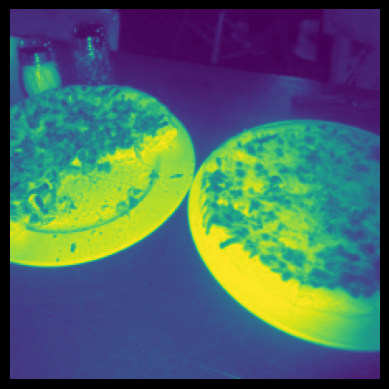

In [ ]:
import matplotlib.pyplot as plt

random_images, random_labels = next(iter(train_data))
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# Display the random image

plt.imshow(random_image)

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image


# Set the background color of the figure as black
fig.set_facecolor(color="black")



In [ ]:
random_images.shape

torch.Size([3, 224, 224])

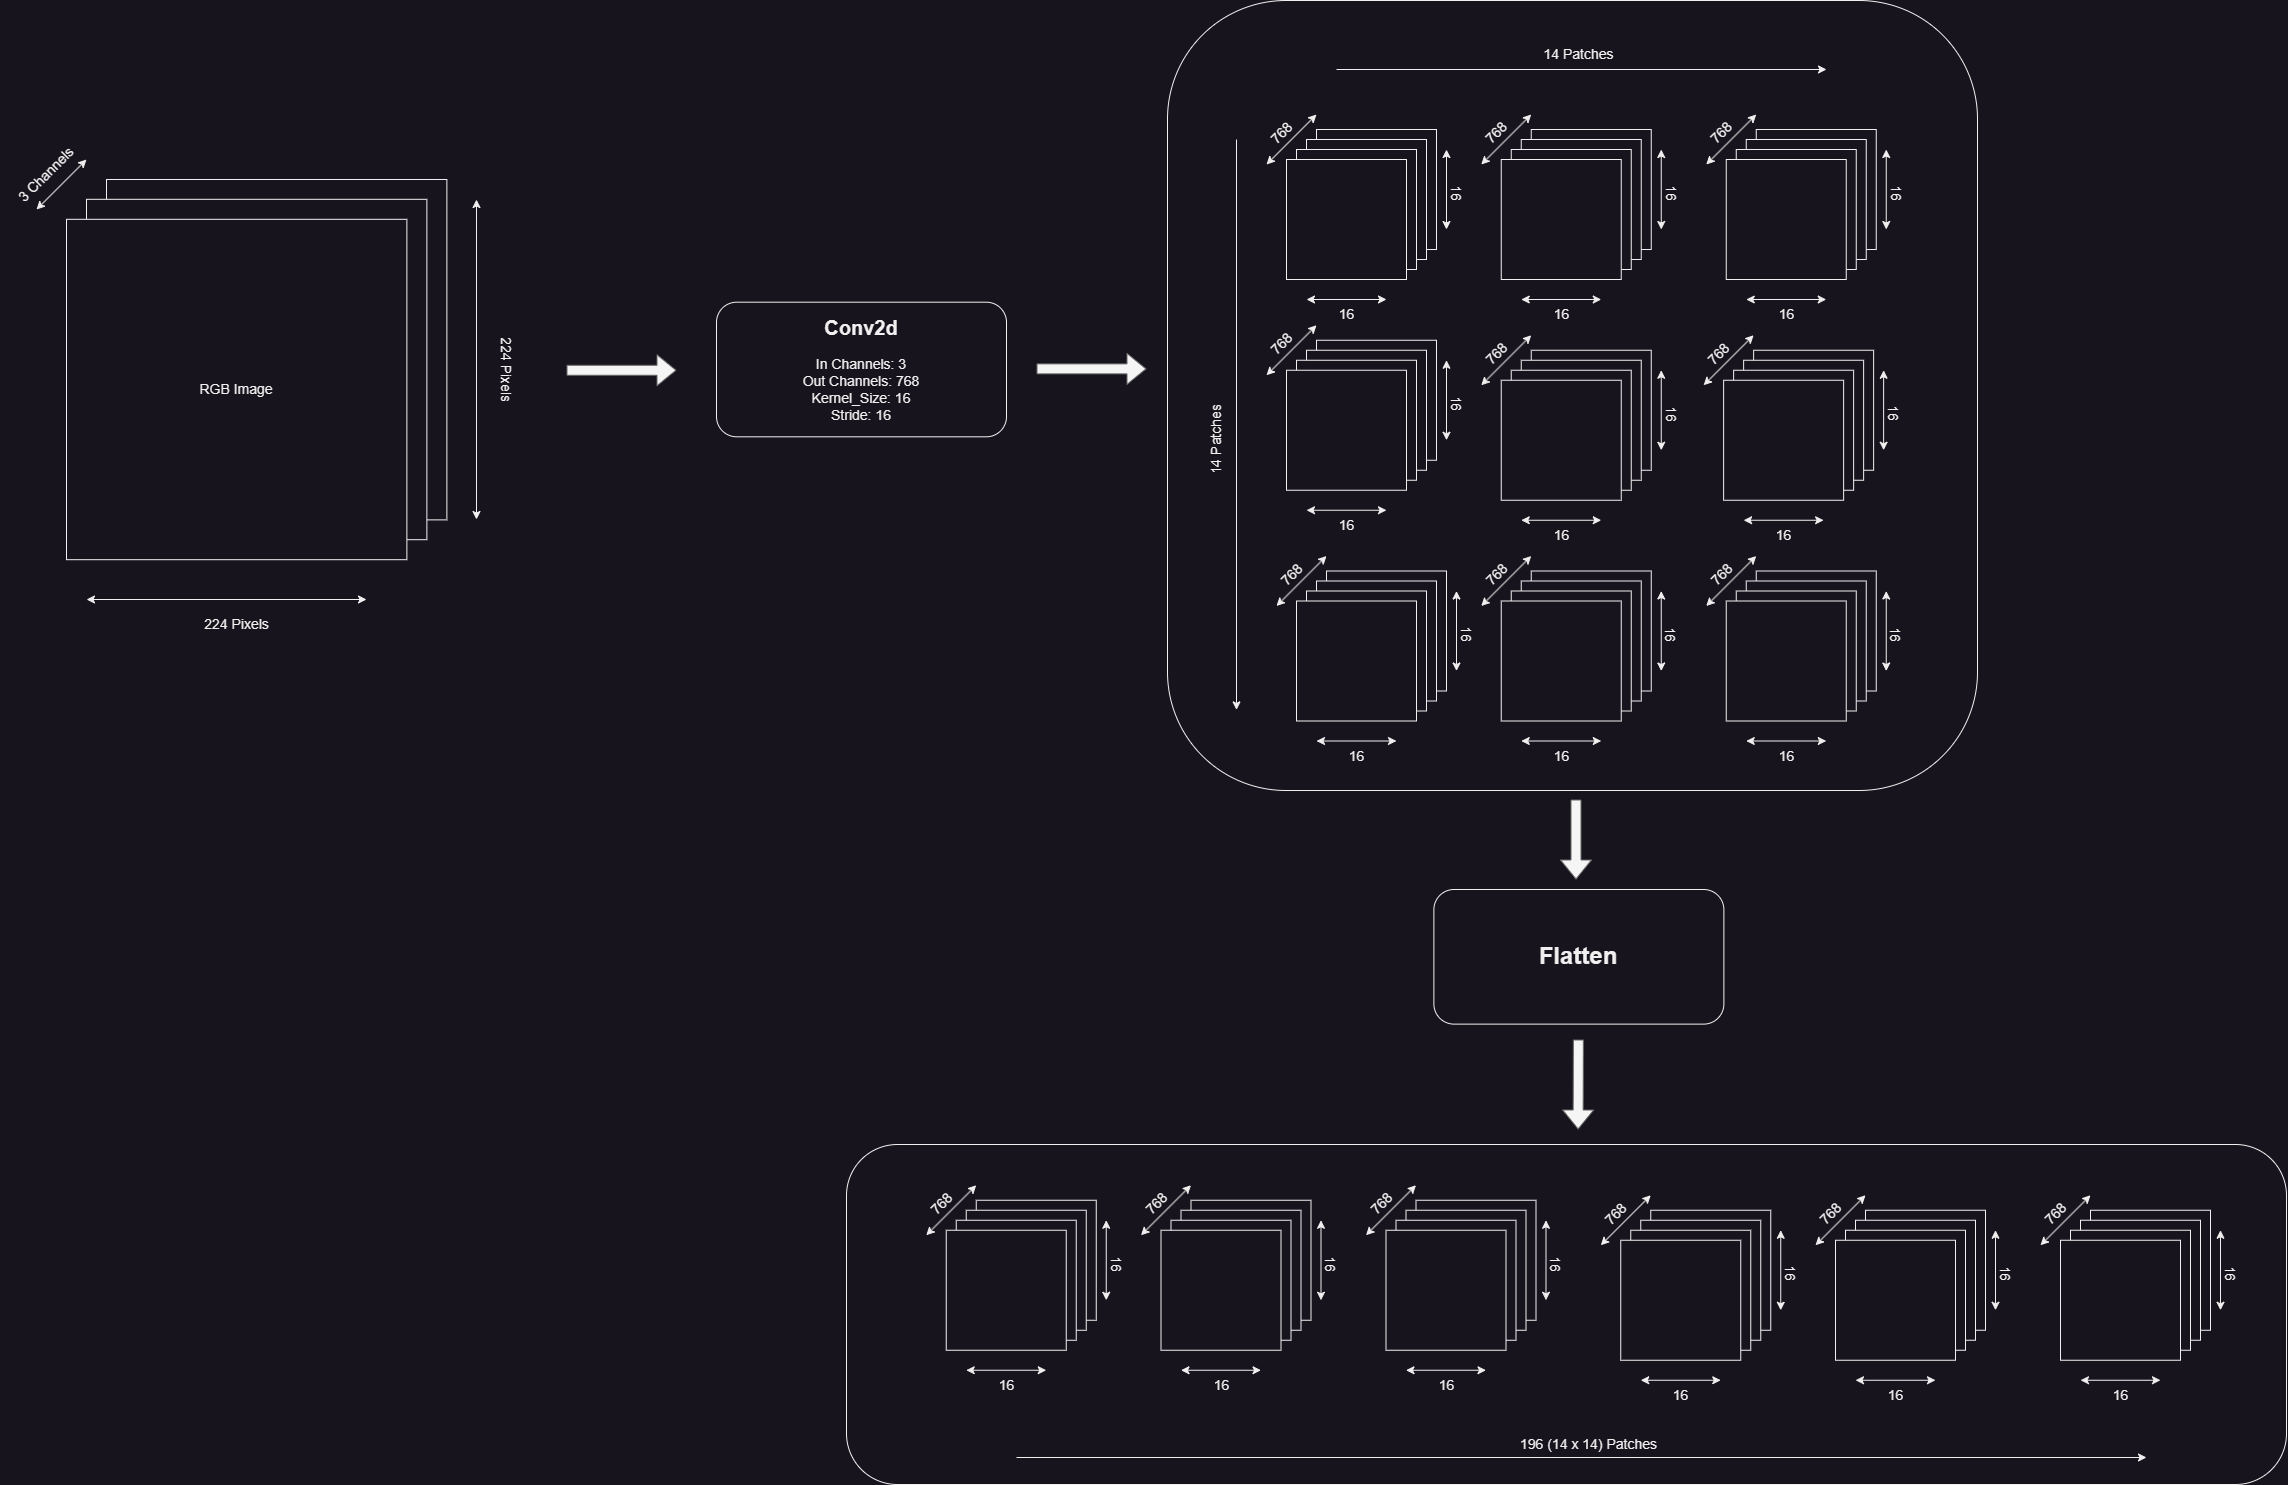

In [ ]:
import torch
import torch.nn as nn
"""
class for patching the frame to patches and get the extrernal class token and embedd them with the flattend from
flatten layer
and finally add positional encoding
"""

class Patch_normlizeing(nn.Module):

    def __init__(self, Patch_DIMS, num_chanels, EMBEDDING_SIZE, FRAME_HEIGHT, FRAME_WIDTH) -> None:
        super(Patch_normlizeing, self).__init__()

        self.FRAME_HEIGHT = FRAME_HEIGHT # the height of the frame
        self.FRAME_WIDTH = FRAME_WIDTH ## and the widht for else
        self.NUM_CHANELS = num_chanels ## number of channels
        self.NUMBER_BATCHES = int((self.FRAME_WIDTH)**2 / (Patch_DIMS**2)) ## number of bacthes
        self.EMBEDDE_SIZE = (Patch_DIMS**2) * num_chanels ## embeddings_size
        self.Patch_DIMS = Patch_DIMS  # Define Patch_DIMS attribute

        self.cls_token = nn.Parameter(torch.rand((1, 1, self.EMBEDDE_SIZE)), requires_grad=True)
        ## the extra token that will, contain the value of class and it should be learnable an compared with
        ##y actuka during training.. untill this layer got learned to get the best learning.

        self.conv_patch=nn.Conv2d(in_channels=3,out_channels=self.EMBEDDE_SIZE,kernel_size=self.Patch_DIMS,stride=16)
        self.flatten = nn.Flatten(start_dim=1, end_dim=2) ## flatten layer is that layer will chane the dimention of batches
                                                             ## 14,14 to 196

        self.pose_encoding = nn.Parameter(torch.rand(1, self.NUMBER_BATCHES+1, self.EMBEDDE_SIZE), requires_grad=True)
        ## layer that define each token by sign to detrmine the pose of it
    def forward(self, frame):
        batches_embed = self.conv_patch(frame)
        print(batches_embed.shape)
        batches_embed = batches_embed.permute(0, 2, 3, 1)

        flattned = self.flatten(batches_embed)
        print(flattned.shape)

        print(self.cls_token.shape)
        the_whal_image = torch.cat((flattned,self.cls_token), dim=1)  # Corrected torch.cat usage
        pose_encoded = the_whal_image + self.pose_encoding

        return pose_encoded


In [ ]:
batch_embd_obj=Patch_normlizeing(16,3,786,224,224)

In [ ]:
random_image.unsqueeze(0).shape

torch.Size([1, 224, 224])

In [ ]:
batch_embd_obj=batch_embd_obj.forward(random_images.unsqueeze(0))

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])


In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [ ]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = 768,
                                                             num_heads = 12
                                                             )

In [ ]:
msa_out=multihead_self_attention_block(batch_embd_obj)

In [ ]:
msa_out.shape

torch.Size([1, 197, 768])

In [ ]:
class MLP(nn.Module):
  def __init__(self,embedd_dim, num_neorns=3027) -> None:
      super().__init__()
      self.normlize=nn.LayerNorm(normalized_shape=embedd_dim)
      self.mlp=nn.Sequential (
          nn.Linear(in_features=embedd_dim,out_features=num_neorns),
          nn.GELU(),
          nn.Dropout(p=.1),
          nn.Linear(in_features=num_neorns,out_features=embedd_dim),
          nn.Dropout(p=.1)
      )
  def forward(self,x):
    return self.mlp(self.normlize(x))


In [ ]:
mlp= MLP(768)

In [ ]:
mlp_ouy=mlp.forward(msa_out)

In [ ]:
mlp_ouy

tensor([[[-0.1220, -0.1257,  0.2610,  ...,  0.2573,  0.1491,  0.0000],
         [ 0.0347, -0.0871,  0.0000,  ...,  0.0000,  0.0858, -0.1205],
         [ 0.1254, -0.2863,  0.0990,  ...,  0.3907,  0.0101, -0.0967],
         ...,
         [-0.0913, -0.0783,  0.1779,  ...,  0.0000,  0.0422,  0.0918],
         [-0.0000, -0.0000,  0.2454,  ...,  0.3677,  0.0741, -0.0479],
         [-0.0955, -0.0655,  0.2078,  ...,  0.5277, -0.0757, -0.1634]]],
       grad_fn=<MulBackward0>)

In [ ]:
class Transformer(nn.Module):
  def __init__(self, embedd_dims,num_heads,num_neorns,attn_dropout = 0.0) -> None:
     super().__init__()
     self.MSA=MultiHeadSelfAttentionBlock(embedd_dims,num_heads,attn_dropout)
     self.MLP=MLP(embedd_dims,3027)
  def forward(self,x):
    msa_out=self.MSA(x)
    mlp_out=self.MLP(msa_out)


    return mlp_out


In [ ]:
encoder=Transformer(768,12,3078)

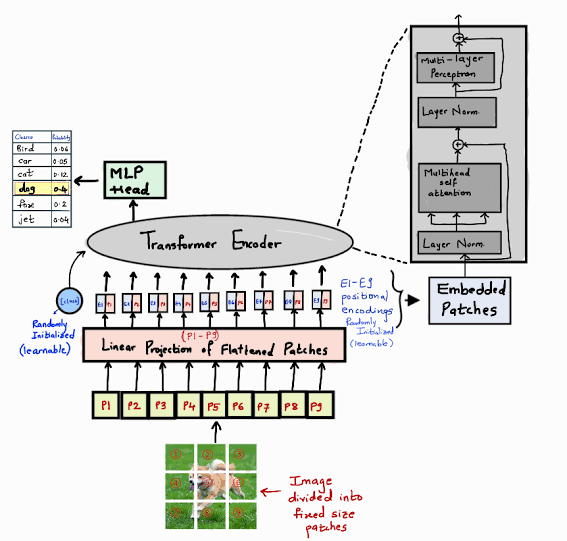

In [ ]:
encoder.forward(batch_embd_obj).shape

torch.Size([1, 197, 768])

In [ ]:
summary(model=encoder)

Layer (type:depth-idx)                                  Param #
Transformer                                             --
├─MultiHeadSelfAttentionBlock: 1-1                      --
│    └─LayerNorm: 2-1                                   1,536
│    └─MultiheadAttention: 2-2                          1,771,776
│    │    └─NonDynamicallyQuantizableLinear: 3-1        590,592
├─MLP: 1-2                                              --
│    └─LayerNorm: 2-3                                   1,536
│    └─Sequential: 2-4                                  --
│    │    └─Linear: 3-2                                 2,327,763
│    │    └─GELU: 3-3                                   --
│    │    └─Dropout: 3-4                                --
│    │    └─Linear: 3-5                                 2,325,504
│    │    └─Dropout: 3-6                                --
Total params: 7,018,707
Trainable params: 7,018,707
Non-trainable params: 0

In [ ]:

class Vit(nn.Module):
  def __init__(self, num_heads,num_neurons,embdings,batch_szie,num_kernals,frame_width,frame_height) -> None:
     super().__init__()

     self.Bact_partitioning_layer=Patch_normlizeing(batch_szie,num_kernals
                                                    ,embdings,frame_width,frame_height)

     self.Tranformer=nn.Sequential(*[Transformer(embdings,num_kernals,num_neurons) for i in range(12)])
     ##this technique is perfect to can create many blocks of transformer heads sequentialy

     self.classifier=nn.Sequential(nn.LayerNorm(normalized_shape=embdings),
                                   nn.Linear(in_features=embdings,out_features=3))
      ## the MLP layer than responsiple for classifcation that depends on the first token output

  def forward(self,x):
      batches=self.Bact_partitioning_layer(x)

      alligns=self.Tranformer(batches[:,0])
      print(batches[:,0].shape)
      print("yes")
      return self.classifier(alligns)



In [ ]:
vit=Vit(12,7030,768,16,3,224,224)

In [ ]:
import torch.nn.functional as F
logits=vit.forward(random_images.unsqueeze(0))

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 768])
yes


In [ ]:
logits

tensor([[-0.1810,  0.1762, -0.1257]], grad_fn=<AddmmBackward0>)

In [ ]:
summary(vit)

Layer (type:depth-idx)                                            Param #
Vit                                                               --
├─Patch_normlizeing: 1-1                                          152,064
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Sequential: 1-2                                                 --
│    └─Transformer: 2-3                                           --
│    │    └─MultiHeadSelfAttentionBlock: 3-1                      2,363,904
│    │    └─MLP: 3-2                                              4,654,803
│    └─Transformer: 2-4                                           --
│    │    └─MultiHeadSelfAttentionBlock: 3-3                      2,363,904
│    │    └─MLP: 3-4                                              4,654,803
│    └─Transformer: 2-5                                           --
│    │    └─MultiHeadSelfAttentionBlock: 3-5                

In [ ]:
optmizer=torch.optim.AdamW(vit.parameters())

In [ ]:
import torch
import torch.nn as nn

# Define the embedding dimension
embedding_dim = 768  # Example embedding dimension

# Create the embedding layer
embedding = nn.Embedding(1, embedding_dim)

# Example input tensor
input_tensor = torch.tensor([[0]])  # Example input tensor with shape [batch_size, sequence_length]

# Get the embeddings for the input tensor
embeddings = embedding(input_tensor)

# Print the shape of the embeddings
print(embeddings.shape)  # Output will be [batch_size, sequence_length, embedding_dim]


torch.Size([1, 1, 768])


In [ ]:
torch.argmax(logits)

tensor(1)

In [108]:
## training sample
losses=[]
citateion2=nn.CrossEntropyLoss()
# Convert target label to floating-point type
optmizer.zero_grad()
y_pred=vit(random_images.unsqueeze(0))
#loss=citateion2(y_pred,label)
loss=citateion2(y_pred,label)


loss.backward()
optmizer.step()
losses.append(loss)


torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 768])
yes


In [109]:
losses

[tensor(0.7044, grad_fn=<NllLossBackward0>)]

In [ ]:
torch.randint(0, 3, (1,))[0]

tensor(1)

In [ ]:
int(y_pred)

0

In [100]:
import torch
import torch.nn as nn

# Example usage of nn.CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Example input logits for one sample and three classes
logits = torch.randn(1, 3)  # Shape: (1, 3)
# Example target label for the single sample
label = torch.tensor([0])  # Assuming the ground truth class index is 0

# Compute the loss
loss = criterion(logits, label)

# Print the loss value
print("Cross-entropy loss:", loss.item())


Cross-entropy loss: 0.527635931968689


In [101]:
logits

tensor([[-0.0985, -2.8187, -0.5620]])

In [102]:
label

tensor([0])